# Modeling sentiment analysis in MXNet with CNN

# What is CNN

A Convolutional Neural Network (CNN) is comprised of one or more convolutional layers (often with a subsampling step) and then followed by one or more fully connected layers as in a standard multilayer neural network. The architecture of a CNN is designed to take advantage of the 2D structure of an input image (or other 2D input such as a speech signal). This is achieved with local connections and tied weights followed by some form of pooling which results in translation invariant features. Another benefit of CNNs is that they are easier to train and have many fewer parameters than fully connected networks with the same number of hidden units.

# Problem 

Sentimenet ananlysis is the use of natual langurage processing(NLP) to determine the attitute expressed by an author in a piece of written text towards a topic, e.g. movie review.  The attitute can be positive, neutral, and negative.  

From a machine learning perspective, sentiment analysis can be treated as a claffisication problem. In the tutorial, we will train a CNN based model for sentiment analysis.  

# How to Use This Tutorial¶
You can use this tutorial by executing each snippet of python code in order as it appears in the notebook.
In this tutorial, we will train a MLP on IMDB dataset which will ultimately produce a neural network that can predict the sentiment of movie review.

# Prerequisites
Familiarity with MXNet, Python, Numpy, basics of MLP networks.
AWS Deep Learning AMI.

# Dataset Overview

The training and testing dataset is the IMDB movie review database.  It contains a total of 50,000 movie reviews that are tagged (labelled) with either a negative(0) or a positive(1) sentiment.  We will split the dataset into 25,000 reviews for training and 25,000 reviews for testing.

# Load Modules

In [1]:
# Load all the libraries and modules
import copy
import numpy as np
import sys
import os
import re

from text import Tokenizer
import mxnet as mx
from matplotlib import pyplot
from six.moves.urllib.request import urlopen
from sequence import pad_sequences

from IPython.display import display 
from IPython.html import widgets

# Enable logging so we will see output during the training
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

/usr/local/lib/python2.7/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


# Process Movie Review Data

The dataset can be downloaded from http://ai.stanford.edu/~amaas/data/sentiment/. The file is then unzipped and processed into traing and testing datasets for training and validation purposes.

In [2]:
#from keras.preprocessing.text import Tokenizer

# We specify number of words to index and this is also the size of vocabulary
num_words = 10000

# This is the directory where the raw review data is located
path = "../data/aclImdb/"

# List all the files for the reviews in the following directories
ff = [path + "train/pos/" + x for x in os.listdir(path + "train/pos")] + \
     [path + "train/neg/" + x for x in os.listdir(path + "train/neg")] + \
     [path + "test/pos/" + x for x in os.listdir(path + "test/pos")] + \
     [path + "test/neg/" + x for x in os.listdir(path + "test/neg")]


TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    return TAG_RE.sub('', text)

input_label = ([1] * 12500 + [0] * 12500) * 2
input_text  = []

for f in ff:
    with open(f) as fin:
        pass
        input_text += [remove_tags(" ".join(fin.readlines()))]
            
# Initialize a tokenizer with the vocabulary size and train on data input text to create a vocabulary for all 
# the unique words found in the text inputs
tok = Tokenizer(num_words)
tok.fit_on_texts(input_text[:25000])
    
        
# Create the training and testing dataset.  Words will be replaced with indexes for the words        
X_train = tok.texts_to_sequences(input_text[:25000])
X_test  = tok.texts_to_sequences(input_text[25000:])
y_train = input_label[:25000]
y_test  = input_label[25000:]


# Addtional Data Processing

We will pad the data to a fixed length and create NDArrayIter to be used for training later

In [3]:
vocabsize = num_words
X = np.concatenate((X_train, X_test), axis=0)

# Specify the maximum length of the reviews we want to process and pad the training and test data 
maxtextlen = 500
X_train = pad_sequences(X_train, maxlen=maxtextlen)
X_test = pad_sequences(X_test, maxlen=maxtextlen)

# convert list to nd array type as mx.io.NDArrayIter takes nd array data type
y_train = np.asarray(y_train)
y_test = np.asarray(y_test)

# Create MXNet NDArray Iterators from the numpy training set and labels.  A batch size specified and the data will
# be shffled.  The iterators will be used as input to train and measure the model performance later.
Batch_Size = 50
trainIter = mx.io.NDArrayIter(X_train, y_train, Batch_Size, shuffle=True)
testIter = mx.io.NDArrayIter(X_test, y_test, Batch_Size, shuffle=True)

# Data Summarization 

Let's take a look at some of the basic metrics of the datasets including number of unique words, unique label values, and the mean and standard deviation of the data set

Number of unique words : 9999

Label value
[0 1]

Review length: 
Mean 216.85 words (158.170289)


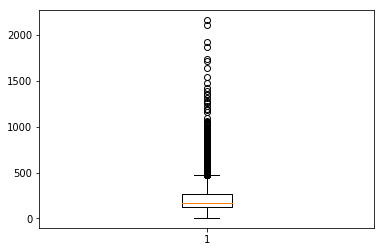

In [4]:
# Let's do some analysis of the data
# Summarize review length
print("Number of unique words : %i" % len(np.unique(np.hstack(X))))
print ('')
print ("Label value")
print (np.unique(y_train))
print ('')
print("Review length: ")

result = [len(x) for x in X]
print("Mean %.2f words (%f)" % (np.mean(result), np.std(result)))

# plot review length distribution
pyplot.boxplot(result)
pyplot.show()

In [5]:
# Let's also take a look at 1 row of the training data
# The integers represent a word in the original text 
print ('Review Example - Coded with word index')
print (X[0:1, ])

Review Example - Coded with word index
[ [8, 182, 4309, 8719, 104, 22, 239, 4, 565, 38, 713, 15, 87, 1217, 10, 18, 76, 25, 53, 1395, 5, 11, 2669, 3946, 2667, 1418, 13, 3, 751, 5, 8719, 35, 6624, 1, 1146, 10, 54, 6, 19, 1229, 318, 252, 5, 3198, 30, 1, 206, 2372, 2234, 5995, 33, 6, 108, 30, 3728, 40, 270, 40, 28, 4, 23, 8796, 7, 1, 4, 28, 4, 10, 3946, 626, 52, 19, 31, 6755, 1950, 15, 1962, 6065, 519, 1, 18, 123, 74, 3, 223, 176, 7, 1, 329, 316, 44, 870, 73, 3, 333, 4, 4309, 6101, 7, 1, 497, 10, 6, 27, 20, 5, 25, 1045, 14, 1, 6101, 82, 33, 43, 60, 553, 4, 23, 18, 227, 3114, 21, 234, 177, 5, 813, 42, 23, 906, 104, 154, 652, 19, 10, 27, 257, 44, 21, 767, 106, 242, 9, 6738, 1, 366, 153, 59, 29, 207, 1572, 68, 4, 808, 398, 128, 1532, 1376]]


# Build a CNN Network


batch size 50
embedding dimensions 300
convolution filters [3, 4, 5]
dropout probability 0.2


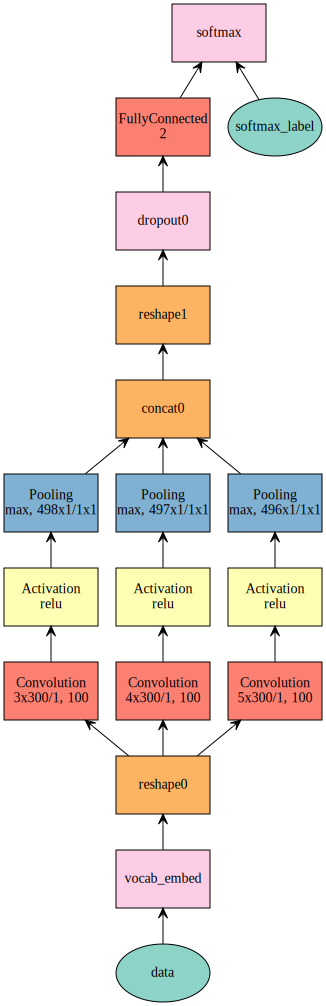

In [6]:
'''
Define batch size and the place holders for network inputs and outputs
'''

batch_size = Batch_Size # the size of batches to train network with
print 'batch size', batch_size

input_x = mx.sym.Variable('data') # placeholder for input data
input_y = mx.sym.Variable('softmax_label') # placeholder for output label


'''
Define the first network layer (embedding)
'''

vocab_size = num_words
sentence_size = maxtextlen

# create embedding layer to learn representation of words in a lower dimensional subspace (much like word2vec)
num_embed = 300 # dimensions to embed words into
print 'embedding dimensions', num_embed

embed_layer = mx.sym.Embedding(data=input_x, input_dim=vocab_size, output_dim=num_embed, name='vocab_embed')

# reshape embedded data for next layer
conv_input = mx.sym.Reshape(data=embed_layer, target_shape=(batch_size, 1, sentence_size, num_embed))


# create convolution + (max) pooling layer for each filter operation
filter_list=[3, 4, 5] # the size of filters to use
print 'convolution filters', filter_list

num_filter=100
pooled_outputs = []
for i, filter_size in enumerate(filter_list):
    convi = mx.sym.Convolution(data=conv_input, kernel=(filter_size, num_embed), num_filter=num_filter)
    relui = mx.sym.Activation(data=convi, act_type='relu')
    pooli = mx.sym.Pooling(data=relui, pool_type='max', kernel=(sentence_size - filter_size + 1, 1), stride=(1,1))
    pooled_outputs.append(pooli)

# combine all pooled outputs
total_filters = num_filter * len(filter_list)
concat = mx.sym.Concat(*pooled_outputs, dim=1)

# reshape for next layer
h_pool = mx.sym.Reshape(data=concat, target_shape=(batch_size, total_filters))


# dropout layer
dropout=0.2
print 'dropout probability', dropout

if dropout > 0.0:
    h_drop = mx.sym.Dropout(data=h_pool, p=dropout)
else:
    h_drop = h_pool
    
# fully connected layer
num_label=2

cls_weight = mx.sym.Variable('cls_weight')
cls_bias = mx.sym.Variable('cls_bias')

fc = mx.sym.FullyConnected(data=h_drop, weight=cls_weight, bias=cls_bias, num_hidden=num_label)

# softmax output
sm = mx.sym.SoftmaxOutput(data=fc, label=input_y, name='softmax')

# set CNN pointer to the "back" of the network
cnn = sm

mx.viz.plot_network(cnn)

# Model Training

Now we are ready to train the model.  We also need to define some hyper-parameters for the model training

In [ ]:
# Set the number of epochs to run
num_epoch = 5

# Assign the network symbol(mlp) to the module class and we will use gpu here.  If cpu is used, then change it 
# content = mx.cpu()
cnn_model = mx.mod.Module(symbol=cnn, context=mx.gpu()) 


# Start training by calling the fit function
cnn_model.fit(trainIter,  # training data               
    eval_data=testIter,  # validation data                            
    optimizer="adam",  # use adam optimizer to train
    optimizer_params={'learning_rate':0.01}, # set learning rate for adam         
    eval_metric='acc',  # report accuracy during training  
    batch_end_callback = mx.callback.Speedometer(Batch_Size, 100), # output progress for each 100 data batches   
    num_epoch=num_epoch) # train data passes indicatd by num_epoch
  


# Model Evaluation
We already evaluate the model during training for each epoch.  Let's also show how to evaluat the model separately from the training step

In [74]:
metric = mx.metric.Accuracy()
cnn_model.score(testIter, metric)
cnn_model.score(testIter, ['mse', 'acc'])

[('mse', 0.47619396555423738), ('accuracy', 0.84372)]

# Saving The Model

Now we have the model fully trained, we can save the model for reuse later. 
2 files will be generated. 
json file captures the network configuration of the neural network,
params file captures the learned parameters for the network

In [9]:
# Save the model
prefix = "sentiment_cnn_"
cnn_model.save_checkpoint (prefix, num_epoch)

INFO:root:Saved checkpoint to "sentiment_cnn_-0005.params"


# Making Prediction

There are 3 steps to making prediction
- Load the saved model
- Prepare the input data
- Make predictiokn with the input data and loaded model

Also we will be using some UI widgets, so run the command below on the server to enable widget extension. 
- jupyter nbextension enable --py --sys-prefix widgetsnbextension


# Load Saved Model
Load the model we just saved, and we will use this model for prediction.  We can also directly use the trained model instead.  Here we just want to demonstrate the model saving and loading process.

In [73]:
# Let's make some prediction using the saved model
# First load the model
num_epoch = 5
maxtextlen = 500
prefix = "sentiment_cnn_"
model = mx.mod.Module.load(prefix, num_epoch, False)

# Now we need to bind the model with a datashape that represents the input, which will be 1 x maxtextlen
model.bind(for_training=False, data_shapes=[('data',(Batch_Size, maxtextlen ) )])

/usr/local/lib/python2.7/dist-packages/mxnet-0.10.0-py2.7.egg/mxnet/module/base_module.py:64: UserWarning: Data provided by label_shapes don't match names specified by label_names ([] vs. ['softmax_label'])
  warnings.warn(msg)


In [71]:
# Some helper function for making the prediction

# This function takes a text string and return a nd array with word indexes 
def prepare_imdb_list(text, maxlen=500, vocabsize=10000, batch_size=1):
    imdb_word_index = tok.word_index
    
    sentence = []

    sentence.append(str(text))
    

    #tokenize the input sentence
    tokens = Tokenizer()
    tokens.fit_on_texts(sentence)

    # get a list of words from the encoding
    words = []
    for iter in range(len(tokens.word_index)):
        words += [key for key,value in tokens.word_index.items() if value==iter+1]
    
    # create a imdb based sequence from the words and specified vocab size
    imdb_seq = []
    for w in words:
        idx = imdb_word_index[w]
        if idx < vocabsize:
            imdb_seq.append(idx)

    # next we need to create a list of list so we can use pad_sequence to pad the inputs
    new_list = []
    new_list.append(imdb_seq)
    new_list = pad_sequences(new_list, maxlen=maxlen)
    
    # Now we need to create a batch for the input based on the batch size to match the shape of input with the target shape of the model
    batch_list = []
    for i in range(batch_size):
        batch_list.append(new_list)
    
    batch_list = np.asarray(batch_list)    
    batch_list = np.reshape(batch_list, (batch_size, maxlen))
                            
    return batch_list


def predict_sentiment(model, text_nd, batch_size):
    sentence_Iter = mx.io.NDArrayIter(text_nd, batch_size=batch_size)
    pred = model.predict(sentence_Iter)
    return pred

def handle_submit(sender):
    text_nd = prepare_imdb_list(inputtext.value, vocabsize=vocabsize, batch_size=Batch_Size)
    pred = predict_sentiment(model, text_nd, Batch_Size)
    outputlabel_0.value = 'Probability for negative sentiment (0):  %0.4f ' % pred.asnumpy()[0:1,0]
    outputlabel_1.value = 'Probability for positive sentiment (1):   %0.4f ' % pred.asnumpy()[0:1,1]
    
    

# Sample Movie Review Text For Testing

Enter samples below or other review text to test the predictive power of the trained model. 

Negative sentiment review samples
- Blake Edwards' legendary fiasco, begins to seem pointless after just 10 minutes. A combination of The Eagle Has Landed, Star!, Oh! What a Lovely War!, and Edwards' Pink Panther films, Darling Lili never engages the viewer; the aerial sequences, the musical numbers, the romance, the comedy, and the espionage are all ho hum. At what point is the viewer supposed to give a damn? This disaster wavers in tone, never decides what it wants to be, and apparently thinks it's a spoof, but it's pathetically and grindingly square. Old fashioned in the worst sense, audiences understandably stayed away in droves. It's awful. James Garner would have been a vast improvement over Hudson who is just cardboard, and he doesn't connect with Andrews and vice versa. And both Andrews and Hudson don't seem to have been let in on the joke and perform with a miscalculated earnestness. Blake Edwards' SOB isn't much more than OK, but it's the only good that ever came out of Darling Lili. The expensive and professional look of much of Darling Lili, only make what it's all lavished on even more difficult to bear. To quote Paramount chief Robert Evans, 24 million dollars worth of film and no picture.

- A mean spirited, repulsive horror film about 3 murderous children. Susan Strasberg is totally wasted in a 5-minute cameo, even though she receives star billing. If your a Julie Brown fan, you'll want to check it out, since she's naked in a couple of shots. All others,avoid.


Positive sentiment review samples
- I went and saw this movie last night after being coaxed to by a few friends of mine. I'll admit that I was reluctant to see it because from what I knew of Ashton Kutcher he was only able to do comedy. I was wrong. Kutcher played the character of Jake Fischer very well, and Kevin Costner played Ben Randall with such professionalism. The sign of a good movie is that it can toy with our emotions. This one did exactly that. The entire theater (which was sold out) was overcome by laughter during the first half of the movie, and were moved to tears during the second half. While exiting the theater I not only saw many women in tears, but many full grown men as well, trying desperately not to let anyone see them crying. This movie was great, and I suggest that you go see it before you judge.

- This is one of my three all-time favorite movies. My only quibble is that the director, Peter Yates, had too many cuts showing the actors individually instead of together as a scene, but the performances were so great I forgive him. Albert Finney and Tom are absolutely marvelous; brilliant. The script is great, giving a very good picture of life in the theatre during World War II (and, therefore, what it was like in the 30s as well). Lots of great, subtle touches, lots of broad, overplayed strokes, all of it perfectly done. Scene after scene just blows me away, and then there's the heartbreaking climax."



# Input Screen For Model Testing

Copy text into the text area and hit the 'Predict Sentiment' button to predict

In [72]:
inputtext = widgets.Textarea()

display(inputtext)

inputbutton = widgets.Button(description='Predict Sentiment')

display(inputbutton)

outputlabel_0 = widgets.HTML()
outputlabel_1 = widgets.HTML()
display(outputlabel_0)
display(outputlabel_1)

inputbutton.on_click(handle_submit)